#### Load MSCOCO Dataset

In [23]:
import os
import json as json
import torch
import torchvision.transforms as transforms
from PIL import Image
from torchvision.models import vgg16
from torch.utils.data import Dataset
from collections import defaultdict
import numpy as np
from tqdm import tqdm

In [24]:
with open("C:/Users/nicho/Downloads/annotations_trainval2017/annotations/captions_val2017.json", "r") as f:
    captions_json = json.load(f)

# Map image_id -> filename
id_to_filename = {img['id']: img['file_name'] for img in captions_json['images']}

# Map image filename -> list of captions
img_to_captions = defaultdict(list)

for ann in captions_json['annotations']:
    img_id = ann['image_id']
    caption = ann['caption']
    file_name = id_to_filename[img_id]
    img_to_captions[file_name].append(caption)


In [191]:
from collections import Counter

import string

def build_vocab(caption_list):
    threshold = 3
    counter = Counter()
    for caption in caption_list:
        # Remove punctuation and split into tokens
        tokens = caption.lower().translate(str.maketrans('', '', string.punctuation)).split()
        counter.update(tokens)

    # Only keep words that meet the minimum threshold
    words = [word for word, cnt in counter.items() if cnt >= threshold]

    vocab = {
        "<pad>": 0,
        "<start>": 1,
        "<end>": 2,
        "<unk>": 3
    }

    for idx, word in enumerate(words):
        vocab[word] = idx + 4

    return vocab

all_captions=[]
for captions in img_to_captions.values():
    for caption in captions:
        all_captions.append(caption)
vocab=build_vocab(all_captions)


In [192]:
vgg = vgg16(pretrained=True)
# list(vgg.children()) gives you the top-level layers of the model: [features, avgpool, classifier].
# [:-1] removes the last layer (classifier).
# nn.Sequential(...) wraps the remaining layers into a new model.
vgg = torch.nn.Sequential(*list(vgg.children())[:-1])
# Enable fine-tuning
for param in vgg.parameters():
    param.requires_grad = True
vgg.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg = vgg.to(device)


vgg_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



c:\Users\nicho\anaconda3\envs\diffusion-env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nicho\anaconda3\envs\diffusion-env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [193]:
# turn the captions into a fixed size length list of tokens, adding start and end to the array as well
def caption_to_tensor(caption, vocab, max_len=20):
    # Remove punctuation and split into tokens
    tokens = caption.lower().translate(str.maketrans('', '', string.punctuation)).split()
    caption_ids = []
    for token in tokens:
        if token in vocab:
            caption_ids.append(vocab[token])
        else:
            caption_ids.append(vocab["<unk>"])

    # Add <start> and <end>
    input_seq = [vocab["<start>"]] + caption_ids
    target_seq = caption_ids + [vocab["<end>"]]

    # Pad both to max_len
    if len(input_seq) < max_len:
        input_seq += [vocab["<pad>"]] * (max_len - len(input_seq))
    else:
        input_seq = input_seq[:max_len]

    if len(target_seq) < max_len:
        target_seq += [vocab["<pad>"]] * (max_len - len(target_seq))
    else:
        target_seq = target_seq[:max_len]

    return torch.tensor(input_seq), torch.tensor(target_seq)

features = []
features_attention = []
caption_inputs = []
caption_targets = []

image_dir = "C:/Users/nicho/Downloads/val2017/val2017"

for file_name, caps in tqdm(img_to_captions.items()):
    img_path = os.path.join(image_dir, file_name)
    try:
        img = Image.open(img_path).convert('RGB')
    except:
        continue
    img_tensor = vgg_transform(img).unsqueeze(0).to(device)
    
    #extract features from the image using VGG
    with torch.no_grad():
        feat_map = vgg(img_tensor).squeeze(0) #[512, 7, 7]
        img_feat = feat_map.view(-1).cpu()
        img_feat_attention = feat_map.view(512, -1).permute(1, 0)  # [49, 512]
       
    for cap in caps:
        features.append(img_feat)
        features_attention.append(img_feat_attention)
        inp, tgt = caption_to_tensor(cap, vocab)
        caption_inputs.append(inp)
        caption_targets.append(tgt)

100%|██████████| 5000/5000 [02:10<00:00, 38.28it/s]


Build RNN

In [ ]:
import torch
import torch.nn as nn

# Par injection, image is concatenated with caption, and treated as the first token
class ImageCaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, hidden_dim=256):
        super(ImageCaptioningModel, self).__init__()

        # 1. Image embedding layer (takes VGG16 output, e.g., 25088-dim)
        self.img_fc = nn.Linear(25088, embed_dim)
        self.img_relu = nn.ReLU()

        # 2. Caption embedding + LSTM
        self.embed = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, batch_first=True)

        # 3. Output layer (to vocab size)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, img_features, captions):
        # Embed image feature vector
        img_embed = self.img_relu(self.img_fc(img_features))  # [batch, embed_dim]

        # add a sequence dimension, making the image behave like the
        # first token in the sequence
        img_embed = img_embed.unsqueeze(1)  # [batch, 1, embed_dim]

        # Embed caption sequence
        caption_embed = self.embed(captions)  # [batch, seq_len, embed_dim]

        # concatenate image and caption embeddings
        # if batch size=32, embed_dim=256, seq_len=20
        # img_embed: [32, 1, 256], caption_embed: [32, 20, 256]
        # so inputs: [32, 1+20, 256], where img_embed is the first token
        inputs = torch.cat((img_embed, caption_embed), dim=1)  # [batch, 1 + seq_len, embed_dim]

        # Pass through LSTM
        lstm_out, _ = self.lstm(inputs)  # [batch, seq_len+1, hidden_dim]

        # Predict output words for each time step
        outputs = self.fc(lstm_out)  # [batch, seq_len+1, vocab_size]

        return outputs


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

class AttentionLayer(nn.Module):
    def __init__(self, encoder_dim, decoder_dim, attention_dim):
        super().__init__()
        self.encoder_att = nn.Linear(encoder_dim, attention_dim)
        self.decoder_att = nn.Linear(decoder_dim, attention_dim)
        self.full_att = nn.Linear(attention_dim, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, encoder_out, decoder_hidden):
        att1 = self.encoder_att(encoder_out)  # [batch, num_pixels, att_dim]
        att2 = self.decoder_att(decoder_hidden).unsqueeze(1)  # [batch, 1, att_dim]
        att = self.full_att(self.relu(att1 + att2))  # [batch, num_pixels, 1]
        alpha = self.softmax(att)  # [batch, num_pixels, 1]
        context = (encoder_out * alpha).sum(dim=1)  # [batch, encoder_dim]
        return context, alpha


import torch
import torch.nn as nn
import torch.nn.functional as F
import random

class ImageCaptioningModelAttention(nn.Module):
    def __init__(self, vocab_size, embed_dim=256, decoder_dim=512, encoder_dim=512, attention_dim=256):
        super().__init__()
        self.encoder_dim = encoder_dim
        self.decoder_dim = decoder_dim
        self.embed_dim = embed_dim

        self.attention = AttentionLayer(encoder_dim, decoder_dim, attention_dim)
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.dropout = nn.Dropout(p=0.5)
        self.decode_step = nn.LSTMCell(embed_dim + encoder_dim, decoder_dim, bias=True)

        self.init_h = nn.Linear(encoder_dim, decoder_dim)
        self.init_c = nn.Linear(encoder_dim, decoder_dim)
        self.context_embed = nn.Linear(encoder_dim, embed_dim)

        self.f_beta = nn.Linear(decoder_dim, encoder_dim)
        self.sigmoid = nn.Sigmoid()
        self.fc = nn.Linear(decoder_dim, vocab_size)

        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.uniform_(-0.1, 0.1)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def init_hidden_state(self, encoder_out):
        mean_encoder_out = encoder_out.mean(dim=1)
        h = torch.tanh(self.init_h(mean_encoder_out))
        c = torch.tanh(self.init_c(mean_encoder_out))
        return h, c

    def forward(self, encoder_out, encoded_captions, sampling_prob=0.0):
        batch_size = encoder_out.size(0)
        num_pixels = encoder_out.size(1)
        seq_len = encoded_captions.size(1)

        embeddings = self.dropout(self.embedding(encoded_captions))
        h, c = self.init_hidden_state(encoder_out)

        predictions = torch.zeros(batch_size, seq_len, self.fc.out_features).to(encoder_out.device)
        alphas = torch.zeros(batch_size, seq_len, num_pixels).to(encoder_out.device)

        prev_words = encoded_captions[:, 0]  # start with <start> token

        for t in range(1, seq_len):
            embed_input = self.embedding(prev_words)  # [batch, embed_dim]
            context, alpha = self.attention(encoder_out, h)
            context = self.dropout(self.sigmoid(self.f_beta(h)) * context)

            lstm_input = torch.cat([embed_input, context], dim=1)
            h, c = self.decode_step(lstm_input, (h, c))
            preds = self.fc(self.dropout(h))
            predictions[:, t, :] = preds
            alphas[:, t, :] = alpha.squeeze(2)

            # scheduled sampling, fixes the same word being predicted over and over again
            # reduce the impact of teacher forcing - the model has perfect knowledge of the previous word
            # during training, but this is not the case during testing, so instead of using the actual
            # previous word, we use the predicted word of the model instead, letting it learn what to do
            # when it makes a mistake so it can learn to correct itself during testing
            teacher_force = random.random() > sampling_prob
            top1 = preds.argmax(1)
            prev_words = encoded_captions[:, t] if teacher_force else top1

        return predictions, alphas



def visualize_attention(image, caption_tokens, alphas, idx2word, save_path=None):
    fig = plt.figure(figsize=(15, 15))
    num_tokens = len(caption_tokens)
    num_rows = int(np.ceil(num_tokens / 5))  # Ensure the number of rows is an integer

    for t in range(num_tokens):
        ax = fig.add_subplot(num_rows, 5, t + 1)  # Use integer `num_rows`
        ax.set_title(idx2word[caption_tokens[t]], fontsize=10)
        img = np.array(image)
        ax.imshow(img)
        alpha = alphas[0, t, :].detach().cpu().numpy().reshape(7, 7)  # assuming 49 = 7x7
        ax.imshow(alpha, alpha=0.6, extent=(0, img.shape[1], img.shape[0], 0), cmap='jet')
        ax.axis('off')

    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

# Label smoothing loss
class LabelSmoothingLoss(nn.Module):
    def __init__(self, classes, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.cls = classes
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x, target):
        true_dist = torch.zeros_like(x)
        true_dist.fill_(self.smoothing / (self.cls - 1))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        return torch.mean(torch.sum(-true_dist * self.log_softmax(x), dim=-1))


In [95]:
from torch.utils.data import Dataset

class CaptionDataset(Dataset):
    def __init__(self, image_features, image_features_attention, caption_inputs, caption_targets):
        self.image_features_attention = image_features_attention
        self.image_features = image_features  # list of [25088]
        self.caption_inputs = caption_inputs  # list of [seq_len]
        self.caption_targets = caption_targets  # list of [seq_len]

    def __len__(self):
        return len(self.image_features)

    def __getitem__(self, idx):

        return (
            torch.tensor(self.image_features[idx]),              # [25088]
            torch.tensor(self.image_features_attention[idx]),    # [49, 512]
            self.caption_inputs[idx],          # Tensor [seq_len]
            self.caption_targets[idx]          # Tensor [seq_len]
        )


In [194]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split the dataset into training and temporary sets (80% train, 20% temp)
train_features, temp_features, train_features_attention, temp_features_attention, train_inputs, temp_inputs, train_targets, temp_targets = train_test_split(
    features, features_attention, caption_inputs, caption_targets, test_size=0.2, random_state=42
)

# Further split the temporary set into validation and test sets (50% val, 50% test from temp)
val_features, test_features, val_features_attention, test_features_attention, val_inputs, test_inputs, val_targets, test_targets = train_test_split(
    temp_features, temp_features_attention, temp_inputs, temp_targets, test_size=0.5, random_state=42
)

# Wrap the splits into datasets
train_dataset = CaptionDataset(train_features, train_features_attention, train_inputs, train_targets)
val_dataset = CaptionDataset(val_features, val_features_attention, val_inputs, val_targets)
test_dataset = CaptionDataset(test_features, test_features_attention, test_inputs, test_targets)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [205]:
vocab_size=len(vocab)
model = ImageCaptioningModel(vocab_size).to(device)
attn_model = ImageCaptioningModelAttention(vocab_size).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=vocab["<pad>"])  # ignore padding tokens
loss_fn_attn = LabelSmoothingLoss(vocab_size, smoothing=0.1)
optimizer = torch.optim.Adam([
    {'params': model.parameters()},
    {'params': vgg.parameters(), 'lr': 0.001}  # smaller learning rate for VGG
])

optimizer_attn = torch.optim.Adam([
    {'params': attn_model.parameters()},
    {'params': vgg.parameters(), 'lr': 1e-5}  # smaller learning rate for VGG
])


In [156]:
num_epochs = 10
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training Phase
    model.train()
    total_train_loss = 0

    for img_feats, _, cap_inputs, cap_targets in train_loader:
        img_feats = img_feats.to(device)              # [batch, 25088]
        cap_inputs = cap_inputs.to(device)            # [batch, seq_len]
        cap_targets = cap_targets.to(device)          # [batch, seq_len]

        optimizer.zero_grad()

        outputs = model(img_feats, cap_inputs)        # [batch, seq_len+1, vocab_size]
        outputs = outputs[:, 1:, :]                   # Remove image position output
        outputs = outputs.reshape(-1, vocab_size)     # [batch*seq_len, vocab_size]
        cap_targets = cap_targets.reshape(-1)         # [batch*seq_len]

        loss = loss_fn(outputs, cap_targets)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for img_feats, _, cap_inputs, cap_targets in val_loader:
            img_feats = img_feats.to(device)              # [batch, 25088]
            cap_inputs = cap_inputs.to(device)            # [batch, seq_len]
            cap_targets = cap_targets.to(device)          # [batch, seq_len]

            outputs = model(img_feats, cap_inputs)        # [batch, seq_len+1, vocab_size]
            outputs = outputs[:, 1:, :]                   # Remove image position output
            outputs = outputs.reshape(-1, vocab_size)     # [batch*seq_len, vocab_size]
            cap_targets = cap_targets.reshape(-1)         # [batch*seq_len]

            loss = loss_fn(outputs, cap_targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Save the best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Validation loss improved. Model saved.")

C:\Users\nicho\AppData\Local\Temp\ipykernel_20504\1601066148.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.image_features[idx]),              # [25088]
C:\Users\nicho\AppData\Local\Temp\ipykernel_20504\1601066148.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.image_features_attention[idx]),    # [49, 512]


Epoch [1/10], Training Loss: 4.2861
Epoch [1/10], Validation Loss: 3.7462
Validation loss improved. Model saved.
Epoch [2/10], Training Loss: 3.4751
Epoch [2/10], Validation Loss: 3.4005
Validation loss improved. Model saved.
Epoch [3/10], Training Loss: 3.1189
Epoch [3/10], Validation Loss: 3.2049
Validation loss improved. Model saved.
Epoch [4/10], Training Loss: 2.8668
Epoch [4/10], Validation Loss: 3.1029
Validation loss improved. Model saved.
Epoch [5/10], Training Loss: 2.6743
Epoch [5/10], Validation Loss: 3.0386
Validation loss improved. Model saved.
Epoch [6/10], Training Loss: 2.5135
Epoch [6/10], Validation Loss: 3.0123
Validation loss improved. Model saved.
Epoch [7/10], Training Loss: 2.3732
Epoch [7/10], Validation Loss: 3.0041
Validation loss improved. Model saved.
Epoch [8/10], Training Loss: 2.2471
Epoch [8/10], Validation Loss: 3.0098
Epoch [9/10], Training Loss: 2.1319
Epoch [9/10], Validation Loss: 3.0164
Epoch [10/10], Training Loss: 2.0237
Epoch [10/10], Validatio

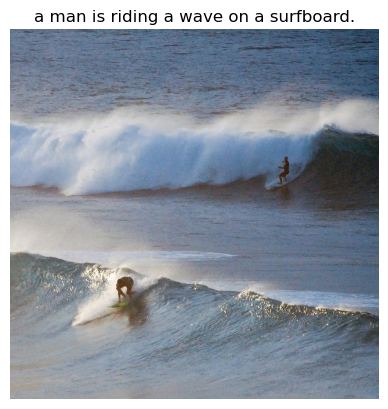

In [157]:
import matplotlib.pyplot as plt
from PIL import Image

def generate_caption(image_path, model, vocab, device, max_len=20):
    """
    Generate a caption for a given image using the trained model.
    """
    # Preprocess the image
    img = Image.open(image_path).convert('RGB')
    img_tensor = vgg_transform(img).unsqueeze(0).to(device)  # Apply the same transform used during training

    # Extract image features using VGG
    with torch.no_grad():
        img_features = vgg(img_tensor).view(-1).unsqueeze(0).to(device)  # [1, 25088]

    # Generate caption
    model.eval()
    caption = []
    input_seq = torch.tensor([vocab["<start>"]], device=device).unsqueeze(0)  # [1, 1]

    for _ in range(max_len):
        with torch.no_grad():
            outputs = model(img_features, input_seq)  # [1, seq_len+1, vocab_size]
            outputs = outputs[:, -1, :]  # Get the last time step's output
            predicted_id = outputs.argmax(dim=-1).item()  # Get the word with the highest probability

        if predicted_id == vocab["<end>"]:
            break

        caption.append(predicted_id)
        input_seq = torch.cat((input_seq, torch.tensor([[predicted_id]], device=device)), dim=1)
        
    # Convert word IDs back to words
    id_to_word = {idx: word for word, idx in vocab.items()}
    caption_words = [id_to_word.get(word_id, "<unk>") for word_id in caption]
    

    return " ".join(caption_words)

# Path to the image
image_path = "C:/Users/nicho/Downloads/val2017/val2017/000000043435.jpg"  # Replace with your image path

# Generate caption
generated_caption = generate_caption(image_path, model, vocab, device)

# Display the image and caption
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.title(generated_caption)
plt.show()

In [206]:
num_epochs = 10
patience = 3  # Number of epochs to wait before stopping if no improvement
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    # Training Phase
    attn_model.train()
    total_train_loss = 0

    for _, img_feats_attention, cap_inputs, cap_targets in train_loader:
        img_feats_attention = img_feats_attention.to(device)  # [batch, 49, 512]
        cap_inputs = cap_inputs.to(device)  # [batch, seq_len]
        cap_targets = cap_targets.to(device)  # [batch, seq_len]

        optimizer_attn.zero_grad()

        outputs, alphas = attn_model(img_feats_attention, cap_inputs)  # [batch, seq_len, vocab_size]
        outputs = outputs[:, 1:, :]  # Remove the output for the <start> token

        # Ensure outputs and targets have the same sequence length
        if outputs.size(1) != cap_targets.size(1):
            min_seq_len = min(outputs.size(1), cap_targets.size(1))
            outputs = outputs[:, :min_seq_len, :]
            cap_targets = cap_targets[:, :min_seq_len]

        outputs = outputs.reshape(-1, vocab_size)  # [batch*seq_len, vocab_size]
        cap_targets = cap_targets.reshape(-1)  # [batch*seq_len]

        loss = loss_fn_attn(outputs, cap_targets)
        loss.backward()
        optimizer_attn.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}")

    # Validation Phase
    attn_model.eval()
    total_val_loss = 0

    with torch.no_grad():
        for _, img_feats_attention, cap_inputs, cap_targets in val_loader:
            img_feats_attention = img_feats_attention.to(device)  # [batch, 49, 512]
            cap_inputs = cap_inputs.to(device)  # [batch, seq_len]
            cap_targets = cap_targets.to(device)  # [batch, seq_len]

            outputs, alphas = attn_model(img_feats_attention, cap_inputs)  # [batch, seq_len, vocab_size]
            outputs = outputs[:, 1:, :]  # Remove the output for the <start> token

            # Ensure outputs and targets have the same sequence length
            if outputs.size(1) != cap_targets.size(1):
                min_seq_len = min(outputs.size(1), cap_targets.size(1))
                outputs = outputs[:, :min_seq_len, :]
                cap_targets = cap_targets[:, :min_seq_len]

            outputs = outputs.reshape(-1, vocab_size)  # [batch*seq_len, vocab_size]
            cap_targets = cap_targets.reshape(-1)  # [batch*seq_len]

            loss = loss_fn(outputs, cap_targets)
            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}")

    # Early Stopping Check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # Save the best model
        torch.save(attn_model.state_dict(), "best_attention_model.pth")
        print("Validation loss improved. Model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in validation loss. Patience counter: {patience_counter}/{patience}")

    if patience_counter >= patience:
        print("Early stopping triggered. Training stopped.")
        break

C:\Users\nicho\AppData\Local\Temp\ipykernel_20504\1601066148.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.image_features[idx]),              # [25088]
C:\Users\nicho\AppData\Local\Temp\ipykernel_20504\1601066148.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.image_features_attention[idx]),    # [49, 512]


Epoch [1/10], Training Loss: 3.3092
Epoch [1/10], Validation Loss: 3.3526
Validation loss improved. Model saved.
Epoch [2/10], Training Loss: 2.8329
Epoch [2/10], Validation Loss: 3.0287
Validation loss improved. Model saved.
Epoch [3/10], Training Loss: 2.6856
Epoch [3/10], Validation Loss: 2.8840
Validation loss improved. Model saved.
Epoch [4/10], Training Loss: 2.5856
Epoch [4/10], Validation Loss: 2.7801
Validation loss improved. Model saved.
Epoch [5/10], Training Loss: 2.5087
Epoch [5/10], Validation Loss: 2.7168
Validation loss improved. Model saved.
Epoch [6/10], Training Loss: 2.4427
Epoch [6/10], Validation Loss: 2.6825
Validation loss improved. Model saved.
Epoch [7/10], Training Loss: 2.3837
Epoch [7/10], Validation Loss: 2.6547
Validation loss improved. Model saved.
Epoch [8/10], Training Loss: 2.3306
Epoch [8/10], Validation Loss: 2.6416
Validation loss improved. Model saved.
Epoch [9/10], Training Loss: 2.2813
Epoch [9/10], Validation Loss: 2.6330
Validation loss improv

Caption: two people riding a wave on top of a wave


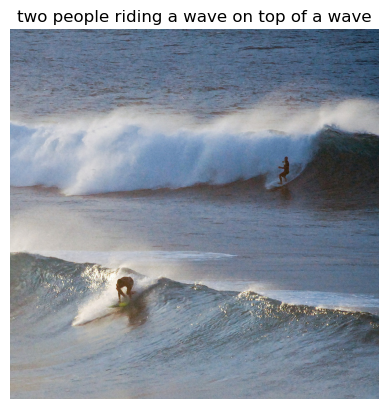

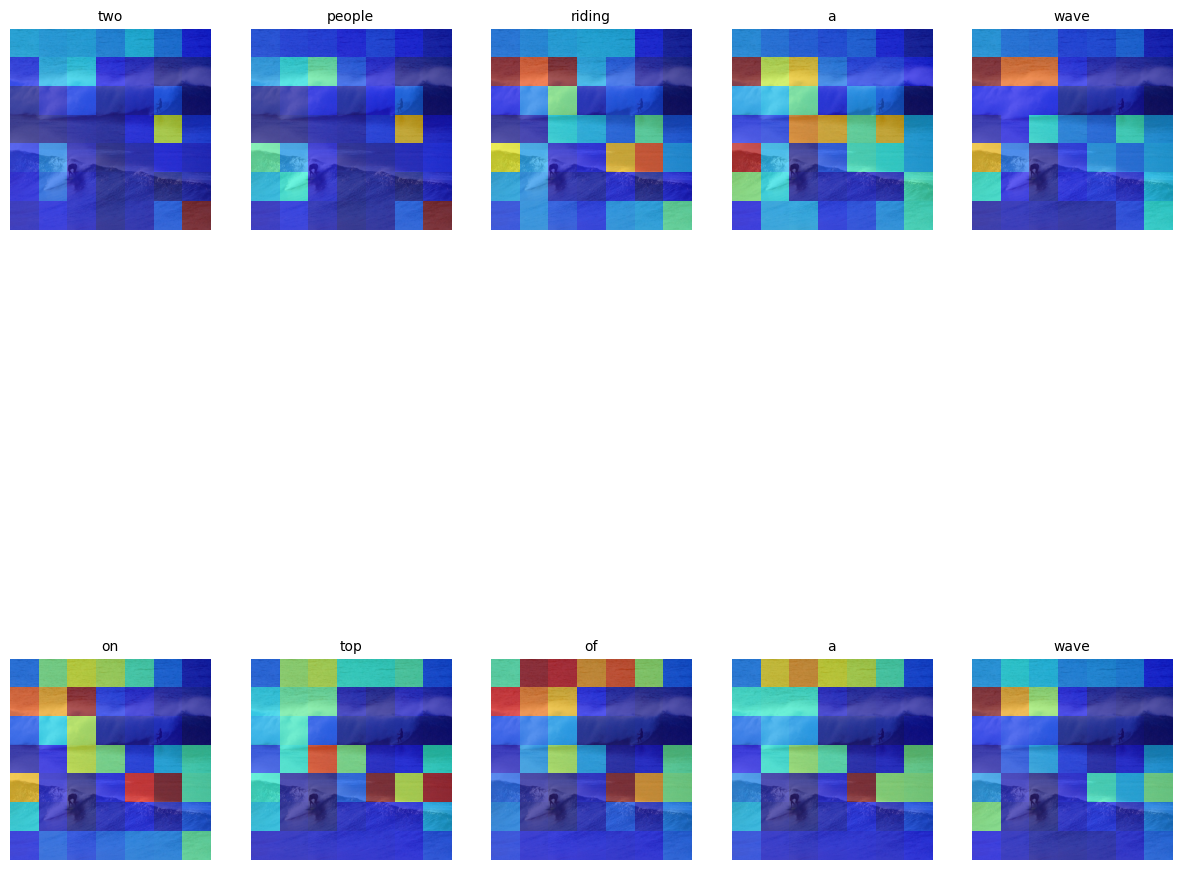

In [207]:
def generate_caption_beam_search_with_attention(model, encoder_out, vocab, device, beam_size=3, max_len=20):
    k = beam_size
    vocab_size = len(vocab)
    idx2word = {idx: word for word, idx in vocab.items()}

    # Expand encoder output for beam size
    encoder_out = encoder_out.expand(k, -1, -1)  # [k, 49, 512]
    h, c = model.init_hidden_state(encoder_out)  # [k, decoder_dim]

    # Initialize sequences, scores, and attention maps
    sequences = torch.tensor([[vocab['<start>']]] * k, device=device)  # [k, 1]
    seq_scores = torch.zeros(k, device=device)  # [k]
    alphas_seq = [[] for _ in range(k)]  # Track attention maps per beam

    complete_seqs, complete_scores, complete_alphas = [], [], []

    for _ in range(max_len):
        # Get the last word in each sequence
        inputs = sequences[:, -1].unsqueeze(1)  # [k, 1]
        embeddings = model.embedding(inputs).squeeze(1)  # [k, embed_dim]

        # Compute attention and context
        context, alpha = model.attention(encoder_out, h)  # [k, 512], [k, 49, 1]
        gate = model.sigmoid(model.f_beta(h))  # [k, 512]
        context = gate * context

        # Pass through LSTM cell
        lstm_input = torch.cat([embeddings, context], dim=1)  # [k, embed_dim + encoder_dim]
        h, c = model.decode_step(lstm_input, (h, c))  # [k, decoder_dim]

        # Compute predictions and probabilities
        preds = model.fc(h)  # [k, vocab_size]
        probs = torch.softmax(preds, dim=1)  # [k, vocab_size]

        # Sample next words based on probabilities
        next_word_idxs = torch.multinomial(probs, num_samples=1).squeeze(1)  # [k]

        # Update sequences and attention maps
        sequences = torch.cat([sequences, next_word_idxs.unsqueeze(1)], dim=1)  # [k, seq_len + 1]
        for i in range(k):
            alphas_seq[i].append(alpha[i].detach().squeeze(1))  # Append attention map

        # Update scores
        seq_scores += torch.log(probs[range(k), next_word_idxs])  # Add log-probabilities

        # Check for completed sequences
        incomplete_idxs = []
        for i, seq in enumerate(sequences):
            if seq[-1] == vocab['<end>']:
                complete_seqs.append(seq.tolist())
                complete_scores.append(seq_scores[i])
                complete_alphas.append(alphas_seq[i])
            else:
                incomplete_idxs.append(i)

        # If all sequences are complete, stop
        if len(incomplete_idxs) == 0:
            break

        # Filter incomplete sequences for the next iteration
        sequences = sequences[incomplete_idxs]
        alphas_seq = [alphas_seq[i] for i in incomplete_idxs]
        seq_scores = seq_scores[incomplete_idxs]
        h = h[incomplete_idxs]
        c = c[incomplete_idxs]
        encoder_out = encoder_out[incomplete_idxs]
        k = len(sequences)

    # If no sequences are complete, use the best incomplete sequence
    if len(complete_scores) == 0:
        complete_seqs = sequences.tolist()
        complete_scores = seq_scores.tolist()
        complete_alphas = alphas_seq

    # Select the best sequence
    best_idx = complete_scores.index(max(complete_scores))
    best_seq = complete_seqs[best_idx]
    best_alphas = complete_alphas[best_idx]

    # Convert indices to words
    words = [idx2word[idx] for idx in best_seq if idx not in {vocab['<start>'], vocab['<end>'], vocab['<pad>']}]
    return words, best_alphas

# Create idx2word mapping from vocab
idx2word = {idx: word for word, idx in vocab.items()}

# Load image and preprocess
image_path = "C:/Users/nicho/Downloads/val2017/val2017/000000043435.jpg"
img = Image.open(image_path).convert('RGB')
img_tensor = vgg_transform(img).unsqueeze(0).to(device)

# Extract VGG features
with torch.no_grad():
    feat_map = vgg(img_tensor).squeeze(0)
    encoder_out = feat_map.view(512, -1).permute(1, 0).unsqueeze(0).to(device)

# Generate caption and attention maps
caption_tokens, alphas = generate_caption_beam_search_with_attention(
    attn_model, encoder_out, vocab, device, beam_size=5
)

# Convert tokens to words
caption = " ".join(caption_tokens)
print("Caption:", caption)

# Display the image and caption
plt.imshow(img)
plt.axis('off')
plt.title(caption)
plt.show()

caption_ids = [vocab.get(word, vocab["<unk>"]) for word in caption_tokens]
visualize_attention(img, caption_ids, torch.stack(alphas).unsqueeze(0), idx2word)